<a href="https://colab.research.google.com/github/iamdsc/humor_detection/blob/master/humor_detection_with_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Humor Detection with Deep Learning using Keras

In [1]:
# required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Flatten,Dense,Dropout,SimpleRNN,LSTM,Conv1D,MaxPooling1D,GlobalMaxPooling1D,GRU
from keras.optimizers import RMSprop
from keras import backend as K

Using TensorFlow backend.


## Getting the data

In [2]:
# Load in the dataset
!git clone https://github.com/iamdsc/humor_detection.git

Cloning into 'humor_detection'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 28 (delta 7), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [3]:
%cd humor_detection/datasets
!ls

/content/humor_detection/datasets
humorous_oneliners.pickle      proverbs.pickle		 wiki_sentences.pickle
oneliners_incl_doubles.pickle  reuters_headlines.pickle


## Loading the dataset

In [0]:
# Read in the lists of sentences from respective pickle files
humour = pd.read_pickle('humorous_oneliners.pickle')
proverb = pd.read_pickle('proverbs.pickle')
wiki = pd.read_pickle('wiki_sentences.pickle')
long_humour = pd.read_pickle('oneliners_incl_doubles.pickle')
reuters = pd.read_pickle('reuters_headlines.pickle')

texts = []
labels = []

# shuffling the different negative samples
neg = proverb+wiki+reuters
np.random.shuffle(neg)

# adding the positive samples
print('No. of positive samples',len(humour))
for line in humour:
  texts.append(line)
  labels.append(1)
  
# taking equal samples from both classes
neg = neg[:len(humour)]

# adding the negative samples
print('No. of negative samples',len(neg))
for line in neg:
  texts.append(line)
  labels.append(0)
  
print('Total no. of samples',len(texts))

## Pre-processing the dataset

In [6]:
# Tokenizing the data
maxlen = 50 # cut off sentences after 50 words
max_words = 10000 # only consider top 10000 common words in dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens'%len(word_index))

# padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)

print('Shape of data tensor:',data.shape)
print('Shape of labels tensor:',labels.shape)

# shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Found 16880 unique tokens
Shape of data tensor: (10502, 50)
Shape of labels tensor: (10502,)


## Loading the pre-trained word embeddings

In [7]:
# due to small size of dataset
# we would use standford's GloVe pre-trained word embeddings

# download the GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-04-14 05:37:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-14 05:37:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  9.94MB/s    in 87s     

2019-04-14 05:38:38 (9.41 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [8]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [9]:
# parsing the GloVe word-embeddings file
embeddings_index = {}

f = open('glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors:'%len(embeddings_index))

# preparing glove word embeddings matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i<max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector # for words not in embedding index values will be zeros

Found 400000 word vectors:


## Building the model

### 1. Simple feed-forward network with dense layers on top of embedding layer 

In [11]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320064    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
___________

In [0]:
# load pre-trained word embeddings into the embedding layer and freeze it
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
# to compute fmeasure as custom metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 2s 247us/step - loss: 0.3801 - acc: 0.8441 - f1: 0.8378 - val_loss: 0.2530 - val_acc: 0.9001 - val_f1: 0.9000
Epoch 2/20
9451/9451 [==============================] - 1s 149us/step - loss: 0.2665 - acc: 0.8933 - f1: 0.8896 - val_loss: 0.2265 - val_acc: 0.9039 - val_f1: 0.9025
Epoch 3/20
9451/9451 [==============================] - 1s 149us/step - loss: 0.2368 - acc: 0.9064 - f1: 0.9025 - val_loss: 0.2183 - val_acc: 0.9125 - val_f1: 0.9134
Epoch 4/20
9451/9451 [==============================] - 1s 149us/step - loss: 0.2184 - acc: 0.9177 - f1: 0.9131 - val_loss: 0.2104 - val_acc: 0.9201 - val_f1: 0.9211
Epoch 5/20
9451/9451 [==============================] - 1s 152us/step - loss: 0.2039 - acc: 0.9207 - f1: 0.9174 - val_loss: 0.2080 - val_acc: 0.9191 - val_f1: 0.9204
Epoch 6/20
9451/9451 [==============================] - 1s 149us/step - lo

In [0]:
# helper function to plot the results
def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  f1 = history.history['f1']
  val_f1 = history.history['val_f1']
  
  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, label='Training acc')
  plt.plot(epochs, val_acc, label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()

  plt.figure()

  plt.plot(epochs, f1, label='Training fmeasure')
  plt.plot(epochs, val_f1, label='Validation fmeasure')
  plt.title('Training and validation fmeasure')
  plt.xlabel('epochs')
  plt.ylabel('f1')
  plt.legend()
  
  plt.show()

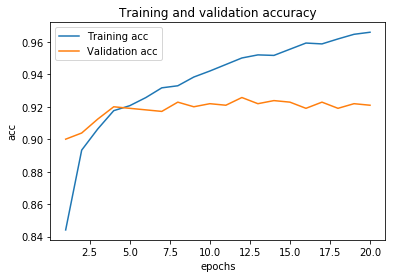

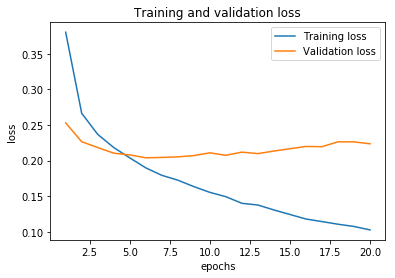

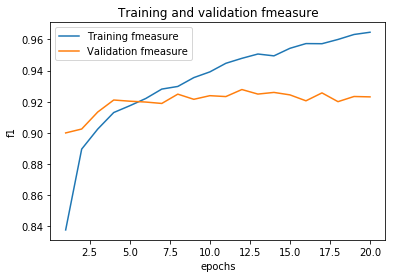

In [16]:
# plotting the results
plot_result(history)

In [37]:
# Building model without pre-trained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3)) # adding regularization

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics = ['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                320064    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,320,129
Trainable params: 1,320,129
Non-trainable params: 0
_________________________________________________________________
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 3s 341us/step - loss: 0.6192

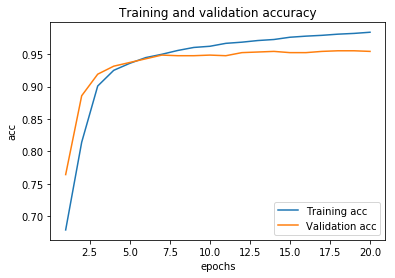

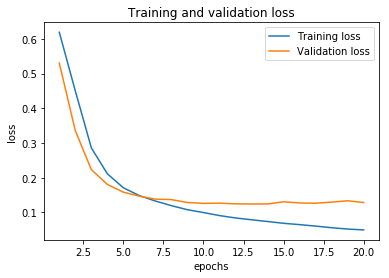

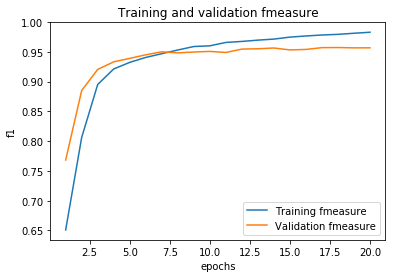

In [38]:
plot_result(history)

### 2. Using Simple RNN layer on top of embedding layer

In [19]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(64, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                6208      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data,labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 9s 926us/step - loss: 0.6288 - acc: 0.6582 - f1: 0.6190 - val_loss: 0.5588 - val_acc: 0.7469 - val_f1: 0.7486
Epoch 2/20
9451/9451 [==============================] - 8s 873us/step - loss: 0.4801 - acc: 0.7892 - f1: 0.7709 - val_loss: 0.3669 - val_acc: 0.8392 - val_f1: 0.8217
Epoch 3/20
9451/9451 [==============================] - 8s 869us/step - loss: 0.3177 - acc: 0.8715 - f1: 0.8608 - val_loss: 0.2582 - val_acc: 0.9049 - val_f1: 0.9033
Epoch 4/20
9451/9451 [==============================] - 8s 873us/step - loss: 0.2536 - acc: 0.8986 - f1: 0.8914 - val_loss: 0.2210 - val_acc: 0.9125 - val_f1: 0.9135
Epoch 5/20
9451/9451 [==============================] - 8s 876us/step - loss: 0.2139 - acc: 0.9159 - f1: 0.9107 - val_loss: 0.2076 - val_acc: 0.9182 - val_f1: 0.9205
Epoch 6/20
9451/9451 [==============================] - 8s 876us/step - loss: 0.1884 - acc: 0.9267 - f1: 0.9217 - val_loss

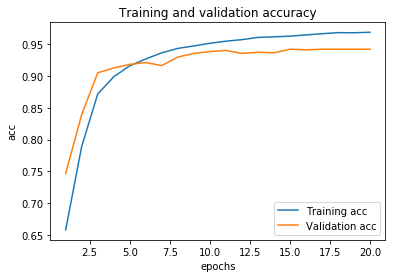

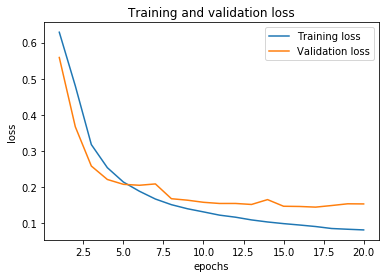

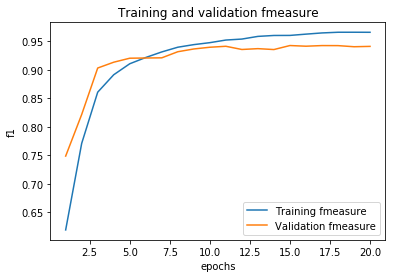

In [21]:
plot_result(history)

### 3. Using LSTM layer on top of the embedding layer

In [22]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 32s 3ms/step - loss: 0.6815 - acc: 0.6523 - f1: 0.5074 - val_loss: 0.6588 - val_acc: 0.8011 - val_f1: 0.7867
Epoch 2/20
9451/9451 [==============================] - 30s 3ms/step - loss: 0.6166 - acc: 0.7706 - f1: 0.7447 - val_loss: 0.5404 - val_acc: 0.8449 - val_f1: 0.8470
Epoch 3/20
9451/9451 [==============================] - 29s 3ms/step - loss: 0.4965 - acc: 0.8213 - f1: 0.8161 - val_loss: 0.3837 - val_acc: 0.8887 - val_f1: 0.8929
Epoch 4/20
9451/9451 [==============================] - 31s 3ms/step - loss: 0.3636 - acc: 0.8741 - f1: 0.8703 - val_loss: 0.2601 - val_acc: 0.9172 - val_f1: 0.9200
Epoch 5/20
9451/9451 [==============================] - 30s 3ms/step - loss: 0.2717 - acc: 0.9036 - f1: 0.9003 - val_loss: 0.2073 - val_acc: 0.9315 - val_f1: 0.9331
Epoch 6/20
9451/9451 [==============================] - 29s 3ms/step - loss: 0.2303 - acc: 0.9182 - f1: 0.9149 - val_loss: 0.18

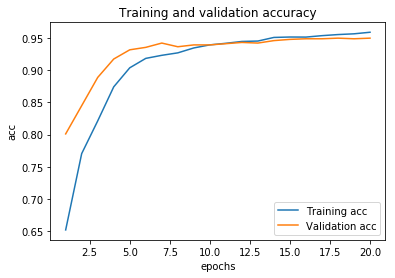

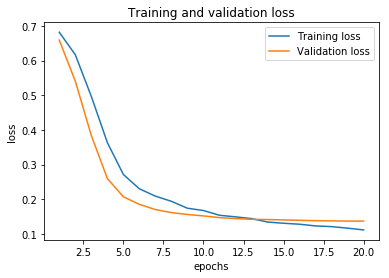

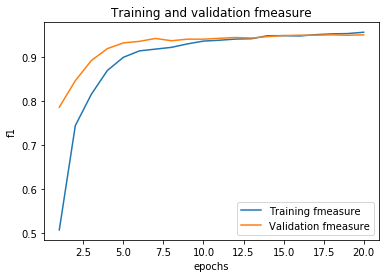

In [24]:
plot_result(history)

### 3. Using two Conv1D layers on top of the Embedding layer

In [25]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 335,521
Trainable params: 335,521
Non-trainable params: 0
_________________________________________________________________


In [26]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 4s 469us/step - loss: 0.6811 - acc: 0.6536 - f1: 0.7003 - val_loss: 0.6554 - val_acc: 0.7631 - val_f1: 0.7886
Epoch 2/20
9451/9451 [==============================] - 2s 198us/step - loss: 0.5966 - acc: 0.7918 - f1: 0.7987 - val_loss: 0.4944 - val_acc: 0.8687 - val_f1: 0.8675
Epoch 3/20
9451/9451 [==============================] - 2s 199us/step - loss: 0.4021 - acc: 0.8749 - f1: 0.8660 - val_loss: 0.3010 - val_acc: 0.9068 - val_f1: 0.9074
Epoch 4/20
9451/9451 [==============================] - 2s 197us/step - loss: 0.2705 - acc: 0.9011 - f1: 0.8917 - val_loss: 0.2247 - val_acc: 0.9153 - val_f1: 0.9147
Epoch 5/20
9451/9451 [==============================] - 2s 198us/step - loss: 0.2183 - acc: 0.9193 - f1: 0.9137 - val_loss: 0.1963 - val_acc: 0.9220 - val_f1: 0.9214
Epoch 6/20
9451/9451 [======================

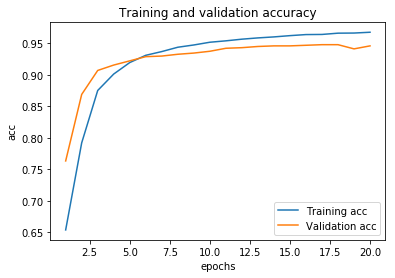

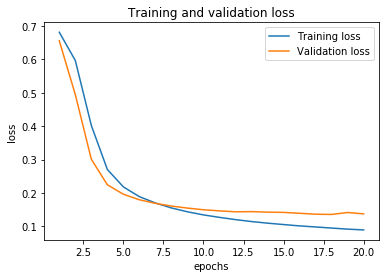

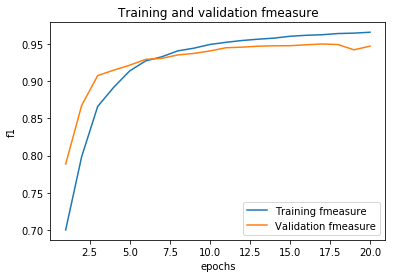

In [27]:
# plot the results
plot_result(history)

### 4. Using LSTM layer on top of Conv1D layer

In [28]:
model = Sequential()
model.add(Embedding(max_words, 32))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))

model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 350,049
Trainable params: 350,049
Non-trainable params: 0
_________________________________________________________________


In [29]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 9s 974us/step - loss: 0.6877 - acc: 0.5563 - f1: 0.2036 - val_loss: 0.6761 - val_acc: 0.6946 - val_f1: 0.6421
Epoch 2/20
9451/9451 [==============================] - 8s 832us/step - loss: 0.6375 - acc: 0.7288 - f1: 0.6759 - val_loss: 0.5625 - val_acc: 0.8049 - val_f1: 0.8013
Epoch 3/20
9451/9451 [==============================] - 8s 828us/step - loss: 0.4764 - acc: 0.8148 - f1: 0.8020 - val_loss: 0.3608 - val_acc: 0.8630 - val_f1: 0.8565
Epoch 4/20
9451/9451 [==============================] - 8s 831us/step - loss: 0.3349 - acc: 0.8712 - f1: 0.8606 - val_loss: 0.2619 - val_acc: 0.9029 - val_f1: 0.9024
Epoch 5/20
9451/9451 [==============================] - 8s 836us/step - loss: 0.2603 - acc: 0.9021 - f1: 0.8955 - val_loss: 0.2204 - val_acc: 0.9115 - val_f1: 0.9107
Epoch 6/20
9451/9451 [==============================] - 8s 842us/step - loss: 0.2241 - acc: 0.9174 - f1: 0.9121 - val_loss

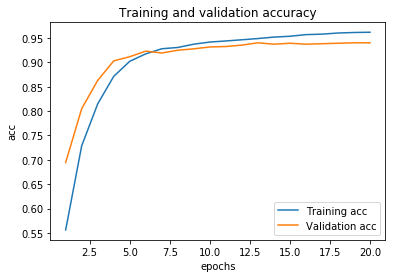

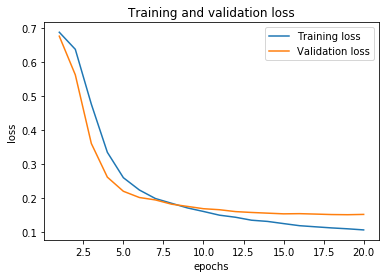

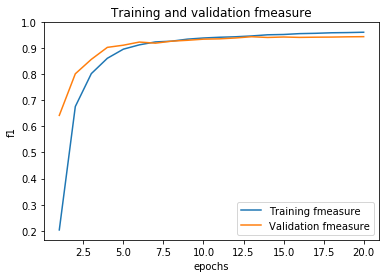

In [30]:
# plot the results
plot_result(history)

### 5. Using GRU layer on top of Conv1D layer

In [31]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 343,841
Trainable params: 343,841
Non-trainable params: 0
_________________________________________________________________


In [32]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 8s 842us/step - loss: 0.6846 - acc: 0.6352 - f1: 0.5031 - val_loss: 0.6663 - val_acc: 0.7364 - val_f1: 0.7149
Epoch 2/20
9451/9451 [==============================] - 6s 688us/step - loss: 0.6263 - acc: 0.7535 - f1: 0.7293 - val_loss: 0.5513 - val_acc: 0.7992 - val_f1: 0.7895
Epoch 3/20
9451/9451 [==============================] - 7s 695us/step - loss: 0.4765 - acc: 0.8216 - f1: 0.8103 - val_loss: 0.3628 - val_acc: 0.8716 - val_f1: 0.8675
Epoch 4/20
9451/9451 [==============================] - 7s 692us/step - loss: 0.3304 - acc: 0.8760 - f1: 0.8683 - val_loss: 0.2571 - val_acc: 0.9001 - val_f1: 0.9011
Epoch 5/20
9451/9451 [==============================] - 7s 690us/step - loss: 0.2604 - acc: 0.9081 - f1: 0.9020 - val_loss: 0.2138 - val_acc: 0.9220 - val_f1: 0.9224
Epoch 6/20
9451/9451 [==============================] - 6s 685us/step - loss: 0.2258 - acc: 0.9193 - f1: 0.9134 - val_loss

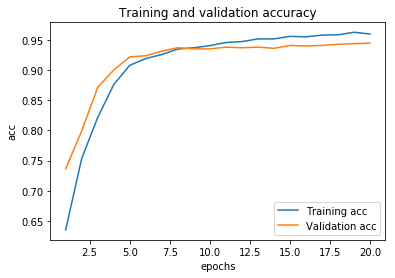

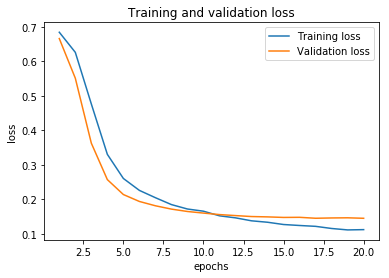

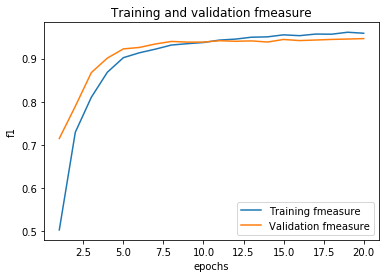

In [33]:
# plot the results
plot_result(history)

### 6. Using two GRU layers on top of two Conv1D layers

In [34]:
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(GRU(32, activation='relu', dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, None, 32)          9312      
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                18624     
__________

In [35]:
# train the model
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc', f1])
history = model.fit(data, labels, epochs=20, batch_size=32, validation_split=0.1)

Train on 9451 samples, validate on 1051 samples
Epoch 1/20
9451/9451 [==============================] - 6s 654us/step - loss: 0.6908 - acc: 0.6640 - f1: 0.6378 - val_loss: 0.6832 - val_acc: 0.7498 - val_f1: 0.7646
Epoch 2/20
9451/9451 [==============================] - 4s 418us/step - loss: 0.6422 - acc: 0.7619 - f1: 0.7690 - val_loss: 0.5268 - val_acc: 0.8202 - val_f1: 0.8236
Epoch 3/20
9451/9451 [==============================] - 4s 420us/step - loss: 0.3962 - acc: 0.8455 - f1: 0.8354 - val_loss: 0.2681 - val_acc: 0.8963 - val_f1: 0.8952
Epoch 4/20
9451/9451 [==============================] - 4s 418us/step - loss: 0.2722 - acc: 0.8999 - f1: 0.8931 - val_loss: 0.2287 - val_acc: 0.9096 - val_f1: 0.9081
Epoch 5/20
9451/9451 [==============================] - 4s 419us/step - loss: 0.2367 - acc: 0.9134 - f1: 0.9071 - val_loss: 0.2249 - val_acc: 0.9049 - val_f1: 0.9031
Epoch 6/20
9451/9451 [==============================] - 4s 420us/step - loss: 0.2147 - acc: 0.9252 - f1: 0.9202 - val_loss

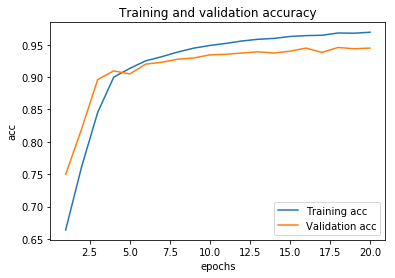

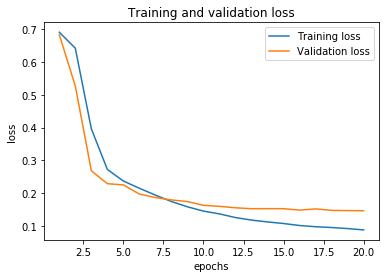

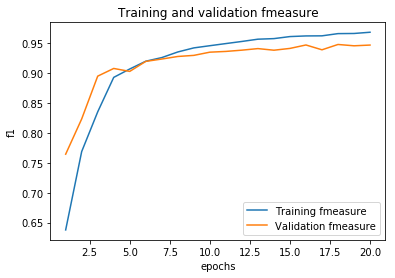

In [36]:
# plot the results
plot_result(history)